In [ ]:
# from datetime import datetime

import numpy as np
import pandas as pd

import tensorflow as tf
# from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping

# from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt

# from gensim import models

import pickle

In [2]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# from tensorflow.python.client import device_lib
# import tensorflow as tf
# print(device_lib.list_local_devices())

In [3]:
BATCH_SIZE = 16
EPOCHS = 50
SAMPLE_SIZE = 20000

# kategorie = ['Education', 'Nonprofit', 'Facility', 'Government', 'Company', 'Healthcare', 'Other', 'Archive']
kategorie = ['Education', 'Nonprofit', 'Facility', 'Government', 'Company', 'Healthcare', 'Archive']
kategorie = ['Education', 'Facility', 'Government', 'Company', 'Healthcare', 'Other', 'Archive']
SLOVNIK = {kat:i for i, kat in enumerate(kategorie)}
NUM_CATEGORY = len(kategorie)

PATH_TO_DATASET = "dataset_lemmatized.csv"
PATH_TO_WORD_EMBEDDINGS = "GoogleNews-vectors-negative300.bin.gz"

In [4]:
df = pd.read_csv(PATH_TO_DATASET)

print(df.shape)
df.head()

(39566, 7)


,index,name,link,lang_eng,valid_dir,value,type
0,0,Australian National University,http://www.anu.edu.au/,1,1,anu newsroom anu study anu research innovation...,Education
1,1,Monash University,http://www.monash.edu/,1,1,monash university one top university australia...,Education
2,2,University of Queensland,http://www.uq.edu.au/,1,1,university queensland university queensland ch...,Education
3,3,Macquarie University,http://mq.edu.au/,1,1,macquarie university tertiary education curren...,Education
4,4,UNSW Sydney,https://www.unsw.edu.au/,1,1,unsw sydney one best university australia unsw...,Education


In [5]:
df["type"].unique()

array(['Education', 'Nonprofit', 'Facility', 'Government', 'Company',
       'Healthcare', 'Other', 'Archive'], dtype=object)

In [6]:
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")].sample(n=SAMPLE_SIZE)
# sample_df = df[(df["type"] == "Company") | (df["type"] == "Education")]
# sample_df = df[df["type"] != "Other"]
sample_df = df[df["type"] != "Nonprofit"] # Vyskusat
# sample_df = df.sample(SAMPLE_SIZE)
# sample_df = df
sample_df.head(5)

,index,name,link,lang_eng,valid_dir,value,type
0,0,Australian National University,http://www.anu.edu.au/,1,1,anu newsroom anu study anu research innovation...,Education
1,1,Monash University,http://www.monash.edu/,1,1,monash university one top university australia...,Education
2,2,University of Queensland,http://www.uq.edu.au/,1,1,university queensland university queensland ch...,Education
3,3,Macquarie University,http://mq.edu.au/,1,1,macquarie university tertiary education curren...,Education
4,4,UNSW Sydney,https://www.unsw.edu.au/,1,1,unsw sydney one best university australia unsw...,Education


In [7]:
print(sample_df['type'].unique())
print(sample_df.shape)

['Education' 'Facility' 'Government' 'Company' 'Healthcare' 'Other'
 'Archive']
(31847, 7)


# Sklearn CountVectorizer (Convolutional)

In [8]:
def pretrained_weights(vectorize_layer):
    weights = []
    for word in vectorize_layer.get_vocabulary():
        if word == '' or word == '[UNK]':
            weights.append(np.zeros((300,)))
        else:
            try:
                weights.append(keyed_vectors.get_vector(word))
            except KeyError:
                weights.append(np.zeros((300,)))

#     print(len(weights))
    return np.asarray(weights)

In [9]:
# Count Vectorizer

X = sample_df['value']

y = sample_df["type"]
y_helper = [np.zeros(NUM_CATEGORY) for _ in range(len(y))]
[np.put(y_h, [SLOVNIK[znak]], 1) for y_h, znak in zip(y_helper, y)]
y = np.asarray(y_helper)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)

In [10]:
EMBEDDINGS_LEN = 300

word2vec_path = PATH_TO_WORD_EMBEDDINGS
keyed_vectors = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# weights = keyed_vectors.vectors  # vectors themselves, a 2D numpy array

In [13]:
vocab_size = 1500
max_len = 500
conv_layers = 3
conv_filters = 256
dropout_size = 0.25
add_dense_layer = True
dense_layer = 256


# Create text vectorization layer
vectorize_layer = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_len,
)
vectorize_layer.adapt(np.array(X_train).flatten())

weights = pretrained_weights(vectorize_layer)

NAME = f"CNN-vocab-{vocab_size}-len-{max_len}-filters-{conv_filter}-dropout-{dropout_size}-dense-{dense_layer}-{datetime.now()}"
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')

# MODEL
model = tf.keras.Sequential()

model.add(tf.keras.layers.Input(shape=(1,), dtype=tf.string))
model.add(vectorize_layer)
model.add(tf.keras.layers.Embedding(
    input_dim=weights.shape[0],
    output_dim=weights.shape[1],
    weights=[weights],
    trainable=False,
))
for i in range(conv_layers):
    model.add(tf.keras.layers.Conv1D(filters=conv_filters, kernel_size=5, activation='relu', input_shape=(max_len, EMBEDDINGS_LEN, )))
    model.add(tf.keras.layers.MaxPool1D(pool_size=4))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dropout(dropout_size))

if add_dense_layer:
    model.add(tf.keras.layers.Dense(dense_layer, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_CATEGORY, activation="softmax"))

model.summary()

print(f"Vocab size: {vocab_size}, Max_len: {max_len}, Conv_layers: {conv_layer}, Conv_filters: {conv_filter}, Dropout: {dropout_size}, Dense_layer: {dense_layer}")

model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(15e-5),
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_model", monitor="val_categorical_accuracy", verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, callbacks=[tensorboard, es, checkpoint], validation_steps=40, verbose=1, initial_epoch=0)

2023-04-24 15:13:31.386588: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-04-24 15:13:31.386628: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-04-24 15:13:31.386664: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1365] Profiler found 4 GPUs
2023-04-24 15:13:31.389418: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcupti.so.10.1
2023-04-24 15:13:31.489867: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1415] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI_ERROR_INSUFFICIENT_PRIVILEGES
2023-04-24 15:13:31.490383: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 500)               0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 300)          450000    
_________________________________________________________________
conv1d (Conv1D)              (None, 496, 256)          384256    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 124, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 120, 256)          327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 30, 256)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 26, 256)           3

2023-04-24 15:13:31.717372: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-04-24 15:13:31.737109: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2299990000 Hz
2023-04-24 15:13:32.770937: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-04-24 15:13:33.236477: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.7
2023-04-24 15:13:34.005774: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-04-24 15:13:34.029309: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/conv1d/conv1d (defined at tmp/ipykernel_20876/1651588754.py:57) ]] [Op:__inference_train_function_1749]

Function call stack:
train_function


In [ ]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, callbacks=[tensorboard, es], validation_steps=40, verbose=1, initial_epoch=11)

In [111]:
model2= tf.keras.models.load_model("CNN-loss-0.5411-acc-0.8286/")

loss, accuracy_d = model2.evaluate(X_test, y_test, verbose=2)
print("Trained model, accuracy: {:5.2f}%".format(100 * accuracy_d))


# for l in model2.layers:
#     print(l.name, l.trainable)
# print("----------------")

model2.layers[1].trainable = True

# for l in model2.layers:
#     print(l.name, l.trainable)


model2.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(1e-6),   # 1e-6
    metrics=[tf.keras.metrics.CategoricalAccuracy()]
)
# model2.summary()
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, validation_steps=40, verbose=1, initial_epoch=4)

200/200 - 2s - loss: 0.5411 - categorical_accuracy: 0.8286
Trained model, accuracy: 82.86%
text_vectorization_32 True
embedding_30 True
conv1d_91 True
max_pooling1d_91 True
conv1d_92 True
max_pooling1d_92 True
conv1d_93 True
max_pooling1d_93 True
flatten_30 True
dropout_30 True
dense_60 True
dense_61 True
----------------
text_vectorization_32 True
embedding_30 True
conv1d_91 True
max_pooling1d_91 True
conv1d_92 True
max_pooling1d_92 True
conv1d_93 True
max_pooling1d_93 True
flatten_30 True
dropout_30 True
dense_60 True
dense_61 True
Epoch 5/5
797/797 [==============================] - 20s 24ms/step - loss: 0.3511 - categorical_accuracy: 0.8892 - val_loss: 0.5399 - val_categorical_accuracy: 0.8317


In [112]:
model2.save("CNN-loss-0.5399-acc-0.8317")

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `

In [11]:
# with open("./model_checkpoints/model_history_CNN_pretrained_embeddings", "wb") as file:
#     pickle.dump(model2.history.history, file)
#
# # Saving model
# pickle.dump(model2, open("./model_checkpoints/model_CNN_pretrained_embeddings", 'wb'))

In [18]:
# with open("./model_checkpoints/model_history_CNN_pretrained_embeddings", "rb") as file:
#     h = pickle.load(file)
#
# print(h)

# Load model
# model2 = pickle.load(open("./model_checkpoints/model_CNN_pretrained_embeddings", 'rb'))
model = tf.keras.models.load_model('CNN-loss-0.5399-acc-0.8317')

In [ ]:
# h_last = h
# h = history.history

# plt.plot(h_last['loss'] + h["loss"], label="loss")
# plt.plot(h_last["val_loss"] + h["val_loss"], label="val_loss")
plt.plot(h["loss"], label="loss")
plt.plot(h["val_loss"], label="val_loss")
plt.title("Loss", fontsize=20)
plt.legend()
plt.show()

In [ ]:
# plt.plot(h_last["categorical_accuracy"] + h["categorical_accuracy"], label="categorical_accuracy")
# plt.plot(h_last["val_categorical_accuracy"] + h["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(h["categorical_accuracy"], label="categorical_accuracy")
plt.plot(h["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.title("Accuracy", fontsize=20)
plt.legend()
plt.show()

In [19]:
# test_loss, test_acc = model.evaluate(gen_val)
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

2023-04-24 15:03:31.379631: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-04-24 15:03:31.388788: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_32/conv1d_91/conv1d (defined at tmp/ipykernel_18318/1920687370.py:2) ]] [Op:__inference_test_function_9412]

Function call stack:
test_function


In [22]:
y_pred = model2.predict(X_test)
y_true = y_test

y_pred = [np.argmax(row) for row in y_pred]
y_true = [np.argmax(row) for row in y_true]

2023-04-24 15:04:15.767344: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR
2023-04-24 15:04:15.776775: E tensorflow/stream_executor/cuda/cuda_dnn.cc:336] Could not create cudnn handle: CUDNN_STATUS_INTERNAL_ERROR


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential_32/conv1d_91/conv1d (defined at tmp/ipykernel_18318/3443791142.py:1) ]] [Op:__inference_predict_function_9623]

Function call stack:
predict_function


In [21]:
correct = 0
n = len(y_true)

for pred, true in zip(y_pred, y_true):
    if pred == true:
        correct += 1

print(f"Accuracy: {round((correct / n) * 100, 2)} %")

NameError: name 'y_true' is not defined

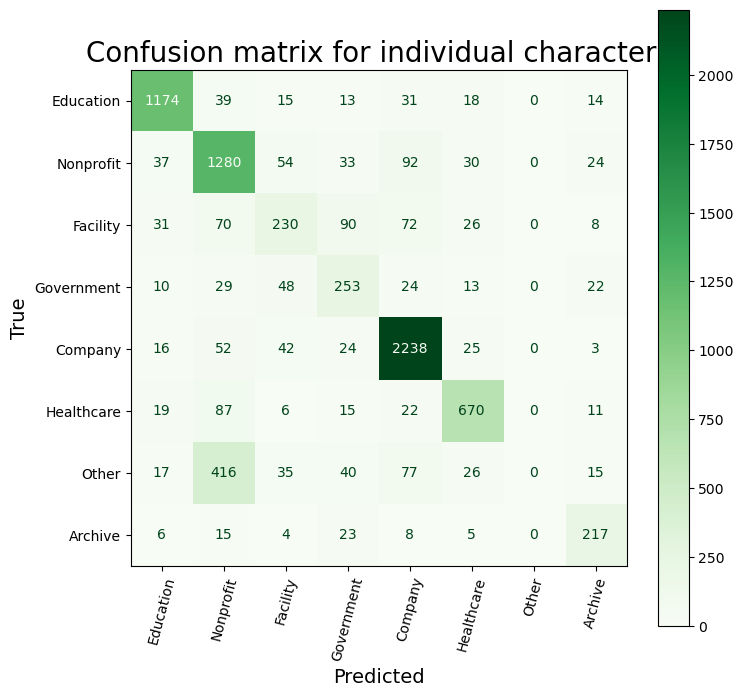

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = [kluc for index in range(len(SLOVNIK.keys())) for kluc, hodnota in SLOVNIK.items() if hodnota == index]
# predictions = y_pred
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, cmap="Greens")
plt.title("Confusion matrix for individual characters", fontsize=20)
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xticks(rotation=75)
plt.xlabel("Predicted", fontsize=14)
plt.ylabel("True", fontsize=14)
plt.show()